In [14]:
import warnings

import botorch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from botorch.fit import fit_gpytorch_mll
from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from tqdm.notebook import tqdm

from bo import fit_gp_model

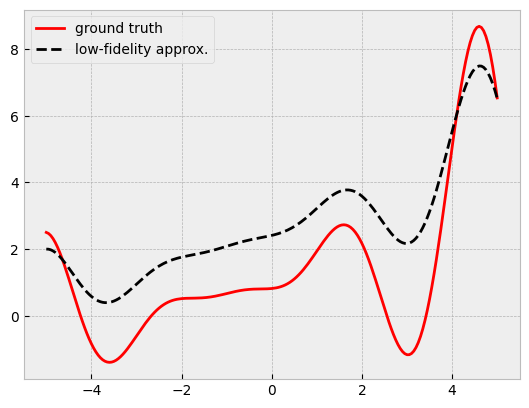

In [9]:
def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1 + x / 3
    return y


def approx_objective(x):
    return 0.5 * objective(x) + x / 4 + 2


lb = -5
ub = +5

bounds = torch.tensor([[lb], [ub]], dtype=torch.float)
fidelities = torch.tensor([0.5, 1.0])


xs = torch.linspace(lb, ub, 201)
ys = objective(xs)
approx_ys = approx_objective(xs)

plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")
plt.legend();

In [10]:
# The size of the training data.
n = 10

torch.manual_seed(0)
train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(n, 1)
train_f = fidelities[torch.randint(2, (n, 1))]
train_x_full = torch.cat([train_x, train_f], dim=1)

In [6]:
def evaluate_all_functions(x_full):
    y = []
    for x in x_full:
        if torch.isclose(x[-1], torch.ones(1)):
            y.append(objective(x[:-1]))
        else:
            y.append(approx_objective(x[:-1]))

    return torch.tensor(y).unsqueeze(-1)

In [11]:
train_y = evaluate_all_functions(train_x_full)
train_y

tensor([[ 0.8137],
        [ 2.4210],
        [ 0.7342],
        [-1.3725],
        [ 1.7799],
        [ 3.6063],
        [ 2.3797],
        [ 5.3423],
        [ 2.2874],
        [ 2.5180]])

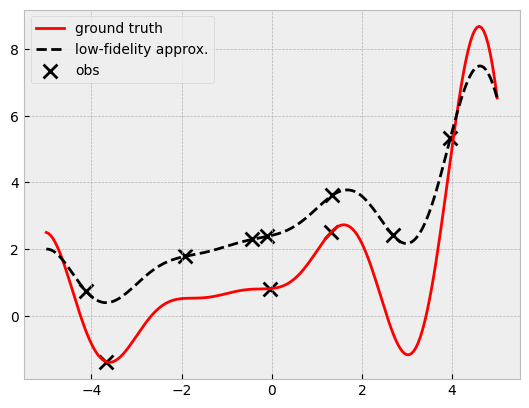

In [13]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")
plt.scatter(train_x, train_y, c="k", marker="x", label="obs", s=100)
plt.legend();

In [25]:
model = SingleTaskMultiFidelityGP(train_x_full, train_y, data_fidelities=[1])
mll = ExactMarginalLogLikelihood(model.likelihood, model)

fit_gpytorch_mll(mll);

/Users/alextanhongpin/Library/Caches/pypoetry/virtualenvs/python-bayesian-optimization-in-action-aU6qUxK9-py3.12/lib/python3.12/site-packages/botorch/models/gp_regression_fidelity.py:135: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  super().__init__(
/Users/alextanhongpin/Library/Caches/pypoetry/virtualenvs/python-bayesian-optimization-in-action-aU6qUxK9-py3.12/lib/python3.12/site-packages/botorch/models/utils/assorted.py:264: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


In [30]:
xs = torch.linspace(-5, 5, 201)
with torch.no_grad():
    pred_dist = model(torch.vstack([xs, torch.ones_like(xs)]).T)
    pred_mean = pred_dist.mean
    pred_lower, pred_upper = pred_dist.confidence_region()

    approx_pred_dist = model(torch.vstack([xs, torch.ones_like(xs) * 0.5]).T)
    approx_pred_mean = approx_pred_dist.mean
    approx_pred_lower, approx_pred_upper = approx_pred_dist.confidence_region()

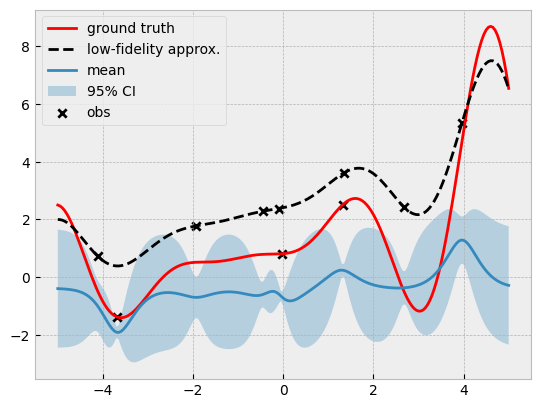

In [31]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.plot(xs, pred_mean, label="mean")
plt.fill_between(xs.flatten(), pred_lower, pred_upper, alpha=0.3, label="95% CI")

plt.scatter(train_x, train_y, c="k", marker="x", label="obs")
plt.legend();

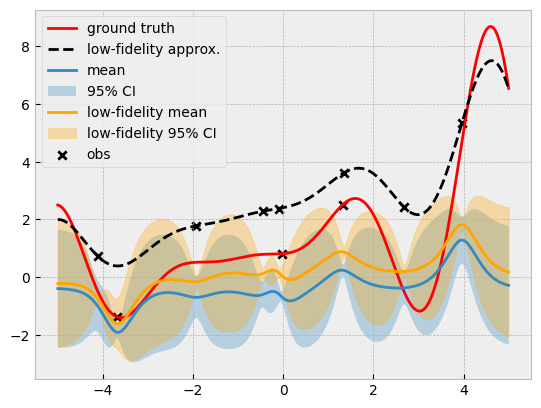

In [32]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.plot(xs, pred_mean, label="mean")
plt.fill_between(xs.flatten(), pred_lower, pred_upper, alpha=0.3, label="95% CI")


plt.plot(xs, approx_pred_mean, c="orange", label="low-fidelity mean")
plt.fill_between(
    xs.flatten(),
    approx_pred_lower,
    approx_pred_upper,
    color="orange",
    alpha=0.3,
    label="low-fidelity 95% CI",
)


plt.scatter(train_x, train_y, c="k", marker="x", label="obs")
plt.legend();

## Balancing information and cost in multi-fidelity optimization
### Modelling the costs of quering different fidelities

In [33]:
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.max_value_entropy_search import qMultiFidelityMaxValueEntropy
from botorch.acquisition.utils import project_to_target_fidelity
from botorch.models.cost import AffineFidelityCostModel
from torch.quasirandom import SobolEngine

cost_model = AffineFidelityCostModel(fixed_cost=10.0, fidelity_weights={1: 1.0})

### Optimizing the amount of information per dollar to guide optimization

In [34]:
num_samples = 1000
torch.manual_seed(0)

cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

sobol = SobolEngine(1, scramble=True)
candidate_x = sobol.draw(num_samples)
candidate_x = bounds[0] + (bounds[1] - bounds[0]) * candidate_x
candidate_x = torch.cat([candidate_x, torch.ones_like(candidate_x)], dim=1)

policy = qMultiFidelityMaxValueEntropy(
    model,
    candidate_x,
    num_fantasies=128,
    cost_aware_utility=cost_aware_utility,
    project=project_to_target_fidelity,
)

In [35]:
with torch.no_grad():
    highf_score = policy(torch.vstack([xs, torch.ones_like(xs)]).T.unsqueeze(1))
    lowf_score = policy(torch.vstack([xs, torch.ones_like(xs) * 0.5]).T.unsqueeze(1))

In [36]:
from botorch.optim.optimize import optimize_acqf_mixed

next_x, acq_val = optimize_acqf_mixed(
    policy,
    bounds=torch.cat([bounds, torch.tensor([0.5, 1.0]).unsqueeze(-1)], dim=1),
    fixed_features_list=[{1: cost.item()} for cost in fidelities],
    q=1,
    num_restarts=20,
    raw_samples=50,
)

In [37]:
next_x, acq_val

(tensor([[3.6530, 1.0000]]), tensor(0.0036))

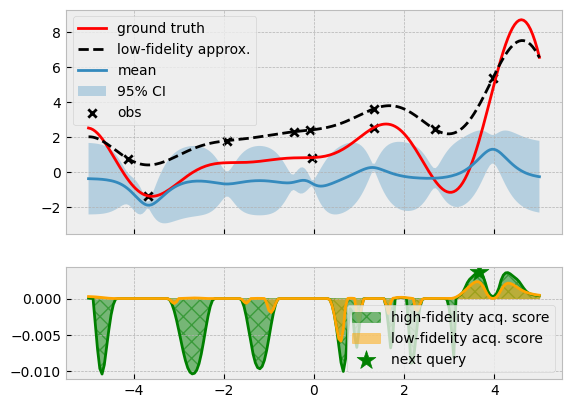

In [38]:
fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [2, 1]})

ax[0].plot(xs, ys, label="ground truth", c="r")
ax[0].plot(xs, approx_ys, "k--", label="low-fidelity approx.")

ax[0].plot(xs, pred_mean, label="mean")
ax[0].fill_between(
    xs.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="95% CI",
)

ax[0].scatter(train_x, train_y, c="k", marker="x", label="obs")

ax[0].legend()

ax[1].plot(xs, highf_score, c="g")
ax[1].fill_between(
    xs.flatten(),
    highf_score,
    0,
    color="g",
    hatch="xx",
    alpha=0.5,
    label="high-fidelity acq. score",
)

ax[1].plot(xs, lowf_score, c="orange")
ax[1].fill_between(
    xs.flatten(),
    lowf_score,
    0,
    color="orange",
    alpha=0.5,
    label="low-fidelity acq. score",
)

ax[1].scatter(
    next_x.flatten()[0],
    acq_val,
    marker="*",
    s=200,
    c="g" if next_x.flatten()[1] == 1 else "orange",
    label="next query",
)

ax[1].legend();

In [39]:
from botorch.acquisition import PosteriorMean
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.optim.optimize import optimize_acqf


def get_final_recommendation(model):
    post_mean_policy = FixedFeatureAcquisitionFunction(
        acq_function=PosteriorMean(model),
        d=2,
        columns=[1],
        values=[1],
    )

    final_x, _ = optimize_acqf(
        post_mean_policy,
        bounds=bounds,
        q=1,
        num_restarts=20,
        raw_samples=50,
    )

    return final_x


final_x = get_final_recommendation(model)
final_x

tensor([[3.9645]])

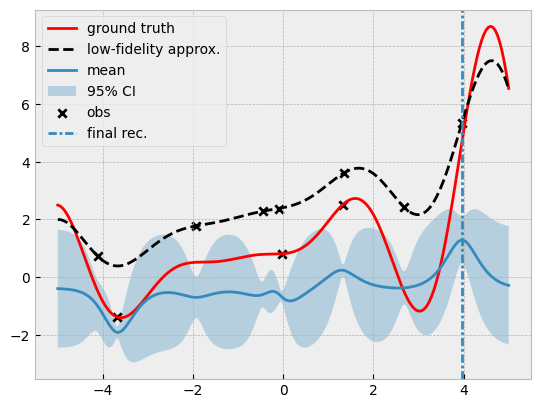

In [40]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.plot(xs, pred_mean, label="mean")
plt.fill_between(
    xs.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="95% CI",
)

plt.scatter(train_x, train_y, c="k", marker="x", label="obs")
plt.axvline(final_x.item(), linestyle=(0, (3, 1, 1, 1)), label="final rec.")

plt.legend();